In [1]:
from IPython import get_ipython


def type_of_script():
    """
    Detects and returns the type of python kernel
    :return: string 'jupyter' or 'ipython' or 'terminal'
    """
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return 'jupyter'
        if 'terminal' in ipy_str:
            return 'ipython'
    except:
        return 'terminal'


if type_of_script() == 'jupyter':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
import cmasher as cmr

import numpy as np
import os, glob, atexit, signal
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle, ax_change_color
from importlib import reload
from copy import deepcopy
from multiprocessing import Pool, shared_memory, Value
from common_func import *

In [2]:
mode1 = 'nh'
database1 = f"/home/jeon/MissingSat/database/{mode1}"
iout1 = 1026
repo1, rurmode1, dp1 = mode2repo(mode1)
snap1 = uri.RamsesSnapshot(repo1, iout1, mode=rurmode1)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']; nout=nout1[nout1 <= iout1]
gals1 = uhmi.HaloMaker.load(snap1, galaxy=True, double_precision=dp1)
hals1 = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp1)

LG1 = pklload(f"{database1}/LocalGroup.pickle")
allsats1 = None; allsubs1 = None; states1 = None
keys1 = list(LG1.keys())
for key in keys1:
    sats = LG1[key]['sats']; subs = LG1[key]['subs']; real = LG1[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats1 = sats if allsats1 is None else np.hstack((allsats1, sats))
    allsubs1 = subs if allsubs1 is None else np.hstack((allsubs1, subs))
    states1 = state if states1 is None else np.hstack((states1, state))
argsort = np.argsort(allsubs1['id'])
allsubs1 = allsubs1[argsort]; states1 = states1[argsort]
dinks1 = allsubs1[states1 == 'dink']
pairs1 = allsubs1[states1 == 'pair']
upairs1 = allsubs1[states1 == 'upair']

print(len(allsubs1), np.unique(states1, return_counts=True))  

1336 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1145,  130,   61]))


In [3]:
mode2 = 'nh2'
database2 = f"/home/jeon/MissingSat/database/{mode2}"
iout2 = 797
repo2, rurmode2, dp2 = mode2repo(mode2)
snap2 = uri.RamsesSnapshot(repo2, iout2, mode=rurmode2)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']; nout=nout2[nout2 <= iout2]
gals2 = uhmi.HaloMaker.load(snap2, galaxy=True, double_precision=dp2)
hals2 = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp2)

LG2 = pklload(f"{database2}/LocalGroup.pickle")
allsats2 = None; allsubs2 = None; states2 = None
keys2 = list(LG2.keys())
for key in keys2:
    sats = LG2[key]['sats']; subs = LG2[key]['subs']; real = LG2[key]['real']
    dink = real[real['state']=='dink']['hid']
    ind = isin(subs['id'], dink)
    subs['dink'][ind] = True; subs['dink'][~ind] = False
    state = np.zeros(len(subs), dtype='<U7')
    state[ind] = 'dink'; state[~ind] = 'pair'
    
    upair = real[real['state']=='upair']['hid']
    ind = isin(subs['id'], upair)
    state[ind] = 'upair'

    allsats2 = sats if allsats2 is None else np.hstack((allsats2, sats))
    allsubs2 = subs if allsubs2 is None else np.hstack((allsubs2, subs))
    states2 = state if states2 is None else np.hstack((states2, state))
argsort = np.argsort(allsubs2['id'])
allsubs2 = allsubs2[argsort]; states2 = states2[argsort]
dinks2 = allsubs2[states2 == 'dink']
pairs2 = allsubs2[states2 == 'pair']
upairs2 = allsubs2[states2 == 'upair']

print(len(allsubs2), np.unique(states2, return_counts=True))

1242 (array(['dink', 'pair', 'upair'], dtype='<U7'), array([1120,   79,   43]))


In [ ]:
# Issue 2
'''
multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/jeon/.conda/envs/jeonpy/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/jeon/rur/rur/uri.py", line 366, in _read_part
    if ('epoch' in target_fields): pointer['epoch'] = epoch[mask]
TypeError: 'NoneType' object is not subscriptable
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jeon/MissingSat/06c_stable_tree.py", line 365, in <module>
    isnap.get_part(nthread=ncpu, target_fields=['x','y','z','m','epoch','id'], exact_box=False, domain_slicing=True, cpulist=cpulist)
  File "/home/jeon/rur/rur/uri.py", line 1969, in get_part
    self.read_part(target_fields=target_fields, cpulist=cpulist, pname=pname, nthread=nthread, python=python)
  File "/home/jeon/rur/rur/uri.py", line 1206, in read_part
    part = self.read_part_py(pname, cpulist, target_fields=target_fields, nthread=nthread)
  File "/home/jeon/rur/rur/uri.py", line 1169, in read_part_py
    r.get()
  File "/home/jeon/.conda/envs/jeonpy/lib/python3.9/multiprocessing/pool.py", line 771, in get
    raise self._value
TypeError: 'NoneType' object is not subscriptable
'''

# NH:
# 13

In [4]:
stree1 = pklload(f"{database1}/stable_progenitors.pickle")
stree2 = pklload(f"{database2}/stable_progenitors.pickle")
rtree1 = pklload(f"{database1}/reduced_tree.pickle")
rtree2 = pklload(f"{database2}/reduced_tree.pickle")

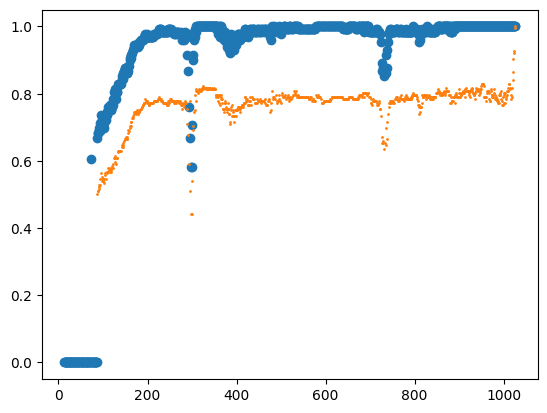

In [5]:
sid = np.random.choice(np.unique(stree1['lastid']))
stmp = stree1[stree1['lastid'] == sid]
rtmp = rtree1[sid]

plt.scatter(stmp['timestep'], stmp['give_score'])
plt.scatter(rtmp['timestep'], rtmp['give_score'], s=1)

In [10]:
stmp.dtype

dtype([('lastid', '<i2'), ('timestep', '<i2'), ('id', '<i2'), ('give_score', '<f8'), ('take_score', '<f8')])

In [30]:
main_prog = pklload(f"{database1}/main_prog/subhalos_{iout1:05d}.pickle")[0]

In [24]:
cpulist = pklload(f"{database1}/main_prog/cpulist/cpulist_01026.pickle")

In [27]:
test =  pklload(f"{database1}/stable_prog/subhalos_01020.pickle")[0]

In [28]:
test

array([(172,   701, 1020, 1,   701,     0, 0,    -1, 0.85097384, 2.33632650e+08, 0.48353455, 0.46795981, 0.47496789,  115.77989692,  34.99073397,  78.78522688,   5456978.0414196 , -31517689.77714361,  1.30029191e+08, 3.90272174e-04, 0.00465653, 0.01881642, 0.00645743, 10.04457198, -0.09402488,  9.95054709, 3.72236734e+01, 41.72253097, 8.52453980e-05, 8.61438820e+07, 1290.84429251,  5.99638758,  62.65721332, 8.52453980e-05, 10441682.66101253, 1.79795317e-05, 1.12304103e-04, 2.96017270e-04, 9.54859014e-06, 2.88515917e-05, 7.13953788e-05, 5.08359338e-05, 2.61907434e-04, 3.74806178e-04, 0, False, 6.44218945e+08,     0.        , 0., 4.12546640e+07, 0, 0., 0., 0., 8.48671664e+07,    0.       ,  439661.74044309, 0.,   693, 0.79581152, 0.88372093),
       (584,  1313, 1020, 1,  1313,     0, 0,    -1, 0.85097384, 7.62242834e+08, 0.4688914 , 0.47782523, 0.51868874,   33.77057039, 112.71088671, -26.87242995, -64905844.71767075,  88762097.8454949 ,  9.53997718e+06, 5.58530798e-04, 0.01681657, 0.00

In [22]:
for iout in np.unique(stree1['timestep'])[::-1][:30]:
    main_prog = pklload(f"{database1}/main_prog/subhalos_{iout:05d}.pickle")[0]
    stmp = stree1[stree1['timestep'] == iout]
    argsort = np.argsort(stmp['lastid'])
    stmp = stmp[argsort]
    ind = isin(main_prog['lastid'], stmp['lastid'])
    mtmp = main_prog[ind]
    argsort = np.argsort(mtmp['lastid'])
    mtmp = mtmp[argsort]
    print(iout, np.sum( stmp['id'] != mtmp['id'] ))
    # print(stmp[0]['lastid'], stmp[0]['id'])
    # print(mtmp[0]['lastid'], mtmp[0]['id'])


1026 0
1025 63
1024 67
1023 66
1022 72
1021 71
1020 74
1019 76
1018 81
1017 85
1016 84
1015 86
1014 81
1013 86
1012 86
1011 87
1010 93
1009 99
1008 94
1007 93
1006 89
1005 86
1004 87
1003 88
1002 86
1001 95
1000 93
999 86
998 88
997 88


In [ ]:
stree1

array([ 0,  0,  0, ..., 18, 31, 60], dtype=int16)

In [44]:
mtmp['id']

array([12, 18, 19, ..., 81, 81, 81], dtype=int32)

In [38]:
np.where(stree2['timestep'] == 0)

(array([973728, 973729, 973730, ..., 991113, 991114, 991115]),)

In [40]:
np.unique(stree2[stree2['lastid']==0]['timestep'])

array([0], dtype=int16)

In [35]:
fnames = os.listdir(f"/storage7/NH2/halo/")
bout = [int(fname[-5:]) for fname in fnames if(fname.startswith("tree_bricks"))]; bout.sort()
bout = np.array(bout); bout = bout[bout <= iout2]
print(bout)

[ 14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31
  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 26

In [31]:
main_prog.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4'), ('r200kpc', '<f8'), ('m200', '<f8'), ('r200', '<f8'), ('mdm_vir', '<f8'), ('mstar_vir', '<f8'), ('mcell_vir', '<f8'), ('mcold_vi

In [24]:
main_prog[0][0]

(351975, 589, 1026, 1, 589, 0, 44, 20368, 0.85361391, 4.61073381e+11, 0.4943338, 0.48610198, 0.47451222, 74.60708546, 83.22969253, 134.24561044, -3.10956856e+11, -5.48242552e+11, 8.00433393e+11, 0.00379802, 0.11050536, 0.04873055, 0.07103276, 42347.39133686, -36155.21504387, 6192.17629299, 0.04083353, 78.60153589, 0.00138576, 3.70174618e+11, 340168.74457477, 97.34193388, 62.09667186, 0.00138576, 1.91082793e+09, 0.00011664, 0.00081584, 0.00191928, 0.0001226, 0.00085415, 0.00131332, 0.00024381, 0.00136748, 0.00312044, 0, False, 9.38242529e+11, 3.57534272e+10, 2.1476229e+10, 1.15791011e+11, 0, 0., 0., 0., 4.79026291e+11, 3.39296077e+10, 4.0578179e+10, 1.99350198e+10, 589, 1., 1.)

In [28]:
stree1['timestep']

array([1026, 1026, 1026, ...,   13,   13,   13], dtype=int16)

In [26]:
leng = len(allsubs1)
stree1['id'][:leng]

array([  693,  1309,  1310, ..., 28532, 28581, 28582], dtype=int16)

In [29]:
main_prog[0]['id'].shape

(3851,)

In [16]:
if(os.path.exists(f"{database1}/shalo_dict.pickle")):
    halos = pklload(f"{database1}/shalo_dict.pickle")
else:
    halos = {'catalog':{}, 'index':{}}
    uri.timer.verbose=0
    for iout in tqdm(np.unique(stree1['timestep'])):
        isnap = snap1s.get_snap(iout)
        ihals = uhmi.HaloMaker.load(isnap, galaxy=False, double_precision=dp1)
        indicies = np.zeros(len(ihals), dtype=int)
        iids = stree1[stree1['timestep'] == iout]['id']
        ihals = ihals[iids-1]
        indicies[iids-1] = np.arange(len(iids))
        halos['catalog'][iout] = ihals
        halos['index'][iout] = indicies   
    pklsave(halos, f"{database1}/shalo_dict.pickle")

  0%|          | 0/852 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
for sub in allsubs1[:5]:
    print(sub['id'])
    rbranch = rtree1[sub['id']]
    rb = rbranch['timestep']*100000 + rbranch['id']
    sbranch = stree1[stree1['lastid'] == sub['id']]
    sbranch = sbranch[sbranch['id']>0]
    sb = sbranch['timestep']*100000 + sbranch['id']
    print( rb[~isin(rb, sb)] )
    print( sb[~isin(sb, rb)] )
    # break

693
[]
[81521286 78021416 77921385 77321439 75821513 10200495]
1309
[65701309 16004180 15404146 15304133 15204138 15004145 11503922]
[65722150 16004181 15404147 15304136 15204135 15004146 11503919]
1310
[]
[102220737 102122154  91420960  91320970  91220999  90421026  89421056
  89221123  89021119  88921110  87321196  87221144  87121185  87021185
  86721135  86321131  86221185  86121151  85821194  85621181  85521211
  85421224  85321245  85221256  85121274  85021259  84821252  84721239
  84621302  84521297  84421304  84321305  84221328  84121319  84021310
  83921353  83821324  83721339  83621370  83521413  83421419  83321408
  83221387  83121343  83021376  82921398  82821350  82721407  82621426
  82521410  82421446  82321428  82221519  82121420  82021451  81921539
  81821548  81721523  81621575  81521591  81421536  81321545  81221501
  81121477  81021560  80921542  80821520  80721559  80621595  80521588
  80421585  80321550  80221512  80121554  80021538  79921612  79821619
  79721569  7

In [6]:
stree1

array([(  693, 1026,  693, 1., 1.), ( 1309, 1026, 1309, 1., 1.),
       ( 1310, 1026, 1310, 1., 1.), ..., (28532,   13,    0, 0., 0.),
       (28581,   13,    0, 0., 0.), (28582,   13,    0, 0., 0.)],
      dtype=[('lastid', '<i2'), ('timestep', '<i2'), ('id', '<i2'), ('give_score', '<f8'), ('take_score', '<f8')])